## Exercise Set 3 for OSM 

### Dynamic Programming with John Stachurski

Exercises for the [OSM](https://bfi.uchicago.edu/osm) bootcamp dynamic programming section.

We will use the following libraries:

In [213]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import time

### Exercise 1.

Using Numba, as discussed in [this lecture](https://lectures.quantecon.org/py/need_for_speed.html), write your own version of NumPy's [interp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html) function, specializing in linear interpolation in one dimension.  

Note that NumPy's function is compiled native machine code and hence is fast.  But try to beat if you can, at least in some scenarios, by using Numba to speed up your code.  Show a time comparison between the two functions, for some suitable choice of test.

In [70]:
der = np.array([0,1,2,3,4,5])
print(der + 1)

[1 2 3 4 5 6]


In [315]:
def f(x):
    return x**5 - 45**3 +4

grid_max = 5
grid_size = 500

xgrid = np.array(np.linspace(1e-5, grid_max, grid_size))
ygrid = np.array(f(xgrid))

def new_interp(xt,x,y):
    Lx,Ly = len(x),len(y)
    m_arr = (y[1:Ly] - y[0:Ly-1])/(x[1:Lx] - x[0:Lx-1])
    bins = np.digitize(xt, x,right=True)
    return y[bins-1] + m_arr[bins-1]*(xt-x[bins-1])


def time_func(N,n):
    inp = 5*np.random.rand(n)
    startnp = []
    endnp = []
    startnew = []
    endnew = []
    for i in range(N):
        startnp.append(time.time())
        k1 = np.interp(inp,xgrid,ygrid)
        endnp.append(time.time())
        startnew.append(time.time())
        k2 = new_interp(inp,xgrid,ygrid)
        endnew.append(time.time())
    print("Time (Numpy)   : ",sum(np.array(endnp) - np.array(startnp)))
    print("Time (New)     : ",sum(np.array(endnew) - np.array(startnew)))
    print("New Pct Slower : ",round(100*abs((sum(np.array(startnew) - np.array(endnew)) - sum(np.array(startnp) - np.array(endnp)))/sum(np.array(startnew) - np.array(endnew))),1),"%")
    return "Test Completed Successfully" 

print(time_func(1000,1000))

Time (Numpy)   :  0.176977157593
Time (New)     :  0.186989545822
New Pct Slower :  5.4 %
Test Completed Successfully


Numba was unable to speed up my function, and actually slowed it down considerably. However, I look forward to messing around with it this week and hopefully improving my result.

### Exercise 2

Using your "Numbafied" linear interpolation function, try to use Numba to additionally speed up the endogenous grid method code from [this lecture](https://lectures.quantecon.org/py/egm_policy_iter.html).  Use CRRA utility and Cobb-Douglas production, as in that lecture, with the following parameter values.


Note: I didn't get much speed up.  I think because the outer loops don't matter much for speed, and hence it doesn't gain us much when we compile them.  

See how you go.

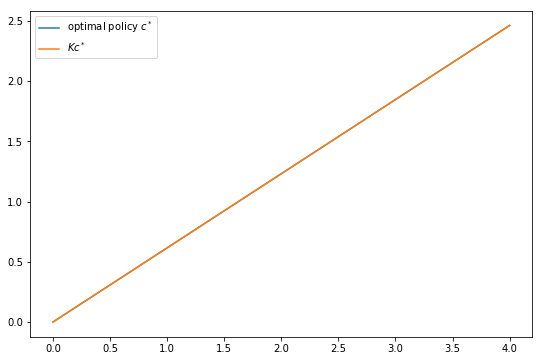

In [268]:
def coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.  
    
    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).

    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: new_interp(x, y, c)
    return Kg

class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)

lg = LogLinearOG()

# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star, c_star = lg.v_star, lg.c_star
u, u_prime, f, f_prime = lg.u, lg.u_prime, lg.f, lg.f_prime

grid_max = 4         # Largest grid point, exogenous grid
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral
grid_ratio = grid_max / grid_size

k_grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

c_star_new = coleman_egm(c_star,
            k_grid, beta, u_prime, u_prime, f, f_prime, shocks)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(k_grid, c_star(k_grid), label="optimal policy $c^*$")
ax.plot(k_grid, c_star_new(k_grid), label="$Kc^*$")

ax.legend(loc='upper left')
plt.show()